# Microlensing: Fitting for parameters

In this notebook, we use a simple Microlensing point-source point-lens model with 3 parameters:
- $t_0$, $u_0$ time and separation during the closest approach between the lens and the source,
- $t_E$, Einstein timescale,

to fit the microlensing candidate data.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

from fink_science.conversion import dc_mag
from fink_client.avroUtils import AlertReader

import numpy as np
import pandas as pd

from mulens_helper import fit_ml_de_simple, mulens_simple

## Load microlensing candidates

We previously found 3 microlensing candidates in ZTF data using Fink between November 2019 and June 2020. The alert data has been exported as Avro files and can be manipulated using `fink_client`:

In [2]:
# Load alert data
r = AlertReader('data/microlensing_object_candidates/')
pdf_object = r.to_pandas()

objects = np.unique(pdf_object.objectId)

To perform the fit, we need first to convert the PSF-fit magnitude into apparent magnitde. The fit is then done on the two bands simultaneously (g&r):

104


/Users/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



    u0 = 0.4104441411166194
    t0 = 2458853.5078663845
    tE = 21.68498460890415
    


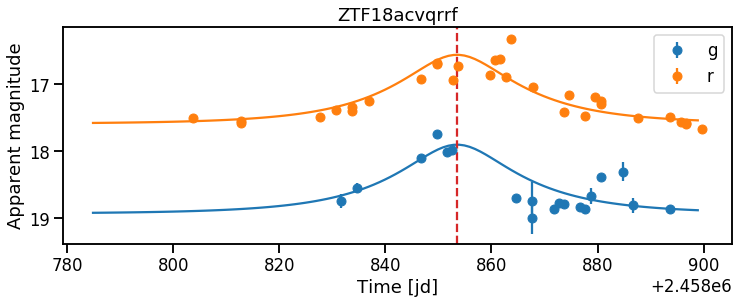

114

    u0 = 0.07039063694410252
    t0 = 2458867.7304791403
    tE = 1.0000000669241949
    


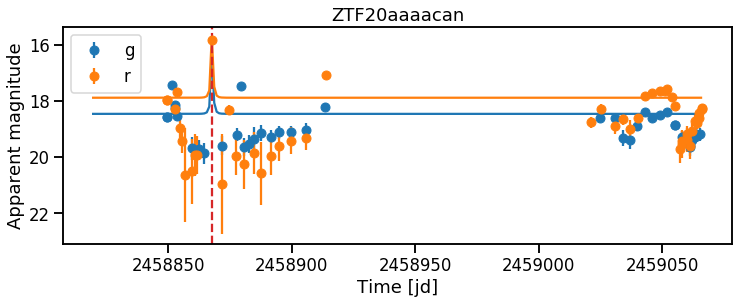

48

    u0 = 0.4001444988481485
    t0 = 2458959.001981896
    tE = 14.47870793605556
    


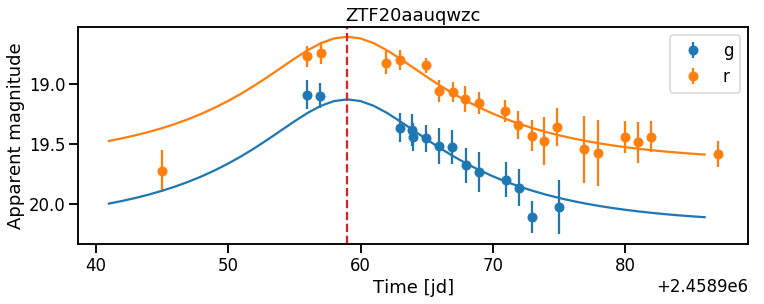

In [10]:
def extract(arrays, dtype=np.float):
    """ extract historical and current measurements from
    all alerts.
    """
    a = []
    for array in arrays:
        a = np.concatenate((a, np.array(array, dtype=dtype)))
    return a

# Do it object-by-object
for objectid in objects:
    # Container for measurements
    subpdf = pd.DataFrame({
        'filtercode': [],
        'mag_g': [],
        'magerr_g': [],
        'mag_r': [],
        'magerr_r': [],
        'time': [],
        'name': []
    })
    pdf = pdf_object[pdf_object.objectId == objectid]
    
    # extract historical and current measurements
    jds_ = extract(list(pdf['cjd'].to_dict().values()))
    jds_, indices = np.unique(jds_, return_index=True)
    subpdf['time'] = jds_
    subpdf['name'] = pdf['objectId']
    
    magpsf = extract(list(pdf['cmagpsf'].to_dict().values()))[indices]
    sigmapsf = extract(list(pdf['csigmapsf'].to_dict().values()))[indices]
    diffmaglim = extract(list(pdf['cdiffmaglim'].to_dict().values()))[indices]
    fids = extract(list(pdf['cfid'].to_dict().values()))[indices]
    
    magnr = extract(list(pdf['cmagnr'].to_dict().values()))[indices]
    sigmagnr = extract(list(pdf['csigmagnr'].to_dict().values()))[indices]
    magzpsci = extract(list(pdf['cmagzpsci'].to_dict().values()))[indices]
    isdiffpos = extract(list(pdf['cisdiffpos'].to_dict().values()), dtype=str)[indices]

    # Compute apparent magnitude from PSF-fit magnitude
    mag_dc, err_dc = np.array([
        dc_mag(i[0], i[1], i[2], i[3], i[4], i[5], i[6])
        for i in zip(
            np.array(fids),
            np.array(magpsf),
            np.array(sigmapsf),
            np.array(magnr),
            np.array(sigmagnr),
            np.array(magzpsci),
            np.array(isdiffpos))
    ]).T
    print(len(mag_dc))

    # Loop over filters
    fig = plt.figure(figsize=(12, 4))
    conversiondict = {1.0: 'g', 2.0: 'r'}
    for fid in np.unique(fids):
        # Select filter
        mask_fid = fids == fid
        
        # Remove upper limits
        maskNone = np.array(magpsf) == np.array(magpsf)
        
        # Remove outliers
        maskOutlier = np.array(mag_dc) < 22
        
        # Total mask
        mask = mask_fid * maskNone * maskOutlier
        
        # plot data
        plt.errorbar(
            jds_[mask], 
            mag_dc[mask], 
            err_dc[mask], 
            ls='', marker='o', label='{}'.format(conversiondict[fid]), color='C{}'.format(int(fid)-1))
        
        # Gather data for the fitter
        subpdf['filtercode'] = pd.Series(fids).replace(to_replace=conversiondict)
        subpdf[f'mag_{conversiondict[fid]}'] = mag_dc
        subpdf[f'magerr_{conversiondict[fid]}'] = err_dc
        
        # Nullify data which is not this filter
        subpdf[f'magerr_{conversiondict[fid]}'][~mask] = None
        subpdf[f'mag_{conversiondict[fid]}'][~mask] = None
        

    # Fit for parameters
    results = fit_ml_de_simple(subpdf)
    msg = f"""
    u0 = {results.u0}
    t0 = {results.t0}
    tE = {results.tE}
    """
    print(msg)
    
    time = np.arange(jds_[0], jds_[-1], 1)
    plt.plot(time, mulens_simple(time, results.u0, results.t0, results.tE, results.magStar_g), color='C0')
    plt.plot(time, mulens_simple(time, results.u0, results.t0, results.tE, results.magStar_r), color='C1')
    
    plt.axvline(results.t0, color='C3', ls='--')

    plt.xlabel("Time [jd]")
    plt.ylabel('Apparent magnitude')
    plt.title(objectid)
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

The candidate `ZTF20aaaacan` can be discarded - it does not appear as microlensing event at all (he passes all search criteria though!). As expected, only `ZTF18acvqrrf` and `ZTF20aauqwzc` give relevant results, with Einstein times around 15-20 and impact parameters around 0.4.

We note that `ZTF18acvqrrf` has an interesting features around `jd=860` and `jd=880`. It would be interesting to use a more complex model and see if this feature means something for the object. 